In [1]:
"""
Sources:

2. https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a

https://www.bloomberg.com/graphics/world-economic-indicators-dashboard/?leadSource=uverify%20wall

- Hierarchical TS: https://www.kaggle.com/code/jagangupta/time-series-basics-exploring-traditional-ts

-Read this after workout: https://www.kaggle.com/code/gargaar/time-series-with-python

# Explore Hierarchical and Grouped Forecasting and also Reconciliation
https://otexts.com/fpp2/hierarchical.html

"""



'\nSources:\n\n2. https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a\n\n'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
from dateutil import relativedelta
from sklearn.model_selection import TimeSeriesSplit

#color_pal = sns.color_palette()
#plt.style.use('fivethirtyeight')


In [ ]:
def first_day_of_month(date):
    """
    Sets all dates to first day of the month
    
    :param date: date object
    
    :return: date object with day replaced with one
    """
    year = date.year
    month = date.month
    return pd.datetime(year, month, 1)

def add_lags(df, num_lags, feature_lag_lst):
    """
    
    :param df: data frame to add lags to
    :param num_lags: # of lags
    :param feature_lag_lst: features to add lags to
    
    :return df, lag_lst: data frame with lags and list of lags
    """
    df = df.copy()
    lag_lst = []
    for feature in feature_lag_lst:
        target_map = df[feature].to_dict()
        for lag in range(1, num_lags):
            df[f'{feature}_lag_{lag}'] = (df.index - pd.DateOffset(months=lag)).map(target_map)
            lag_lst.append(f'{feature}_lag_{lag}')
        
    # df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364
    # df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map) # 728
    # df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map) # 1092
    return df, lag_lst

def generate_lagged_features_lst(lagged_attr, num_lags):
    """
    Generates a lagged feature list
    TODO: lag_lst from above can probably replace this
    
    :param lagged_attr: attributes to add the "lag_#" tag
    :param num_lags: number of lags
    
    :return features: list of features with the "lag_#" tag
    """
    
    features = []
    for attr in lagged_attr:
        for i in range(1,num_lags):
            features.append(f"{attr}_lag_{i}")
    return features

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    #df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    #df['dayofyear'] = df.index.dayofyear
    #df['dayofmonth'] = df.index.day
    #df['weekofyear'] = df.index.isocalendar().week
    return df

In [ ]:
def preprocess(df):
    df = df.copy()
    df.columns = [signal.lower().replace(" ", "_") for signal in df.columns] # upper to lower and replace space with underscores
    df['date'] = pd.to_datetime(df['date']) # To date-time object conversion
    df = df.resample('M', on='date').mean() # Up-sample
    df.index = df.index.map(first_day_of_month) # Set index
    return df

In [ ]:
qqq_df = pd.read_csv("QQQ.csv")
nvda_df = pd.read_csv("NVDA.csv")
spy_df = pd.read_csv("SPY.csv")
vti_df = pd.read_csv("VTI.csv")


qqq_df = preprocess(qqq_df)
nvda_df = preprocess(nvda_df)
spy_df = preprocess(spy_df)
vti_df = preprocess(vti_df)


df = nvda_df.copy()
df["qqq_close"] = qqq_df["close"]
df["spy_close"] = spy_df["close"]
df["vti_close"] = vti_df["close"]

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()


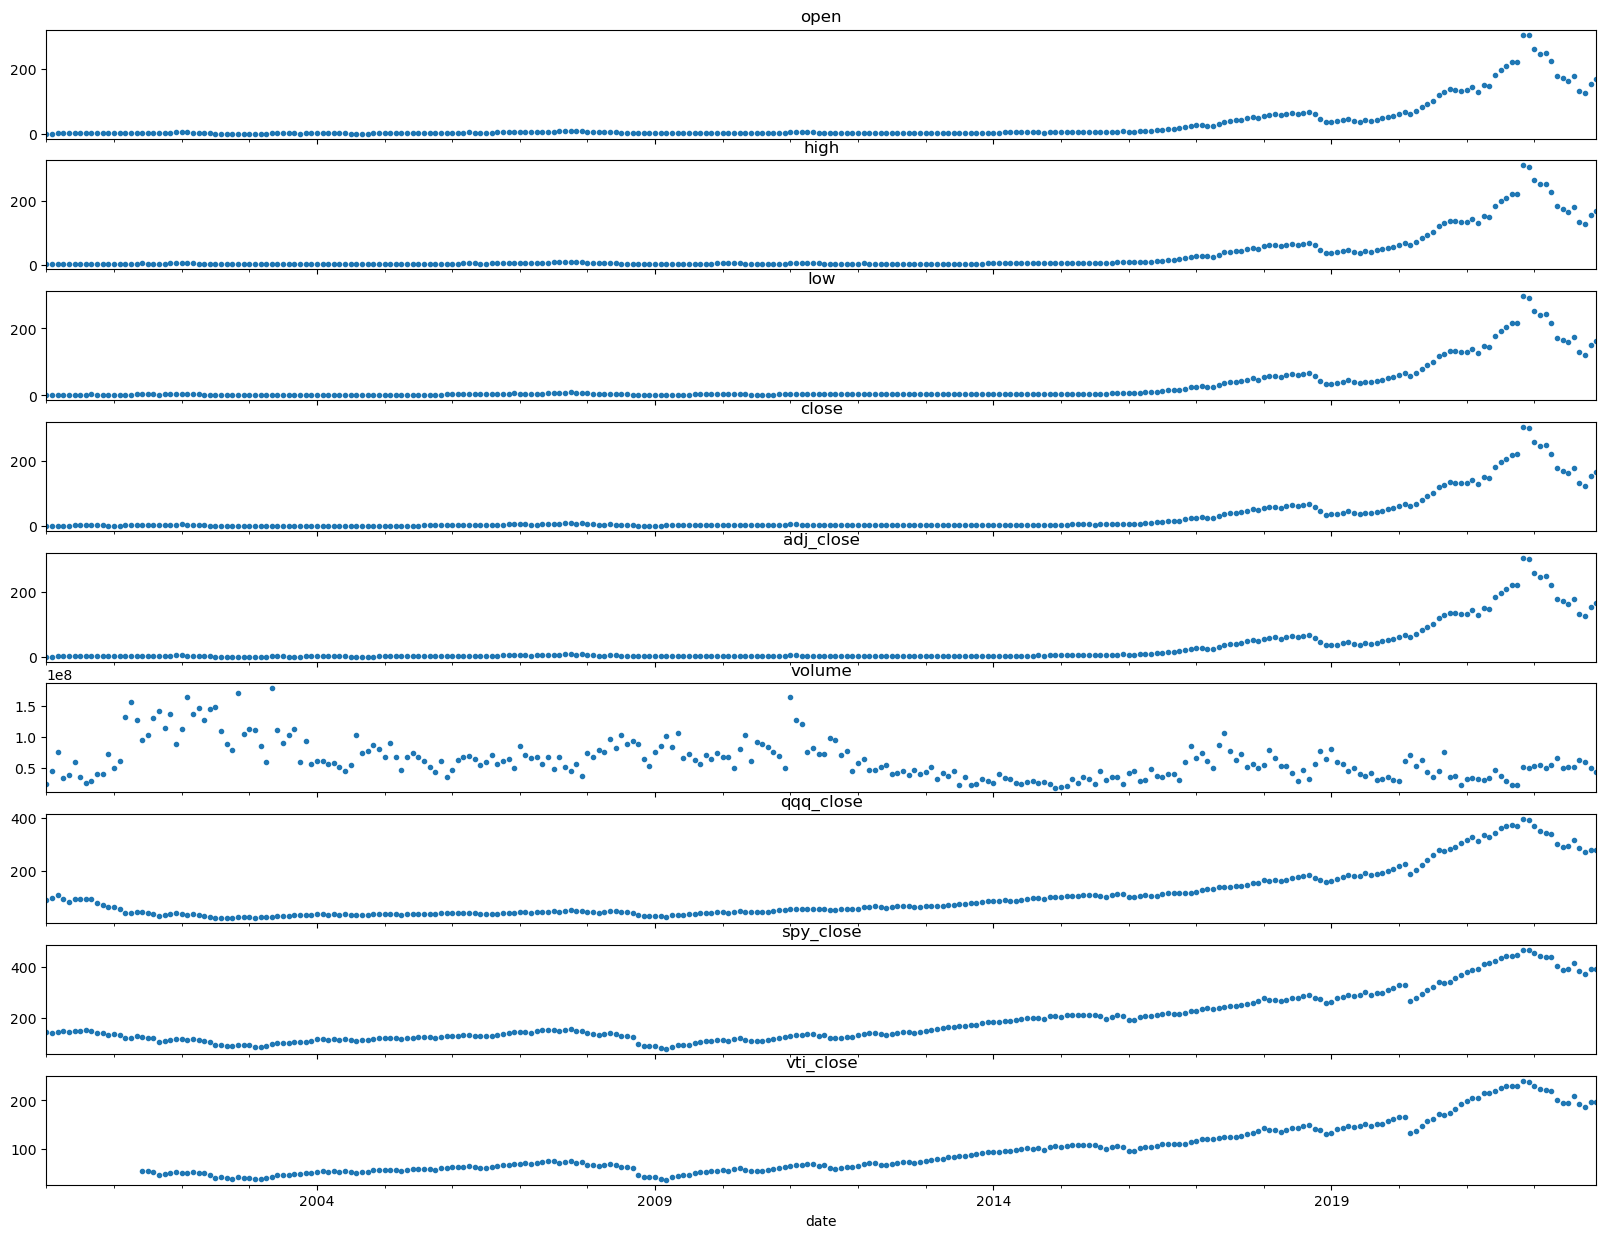

In [ ]:
fig, axs = plt.subplots(len(df.columns), 1, figsize=(15, 15), sharex=True)
cnt = 0
for signal in df.columns:
    df[signal].plot(ax=axs[cnt], style='.',
            figsize=(20, 15),
            #color=color_pal[signal],
            title=signal)
    cnt +=1
plt.show()

## Outlier Checks

<AxesSubplot:ylabel='Frequency'>

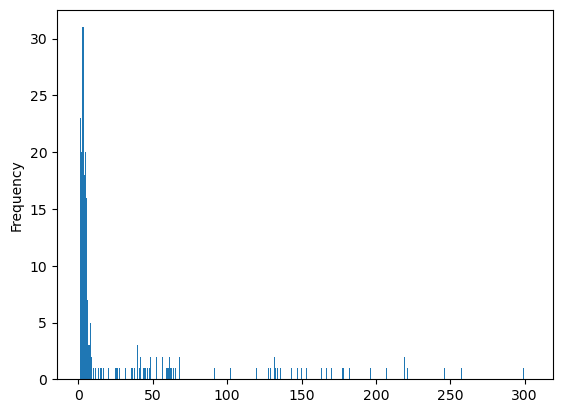

In [ ]:
df['close'].plot(kind='hist', bins=500)

In [ ]:
df.query('close > 200')['close'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

NameError: name 'color_pal' is not defined

## Train/Test Split

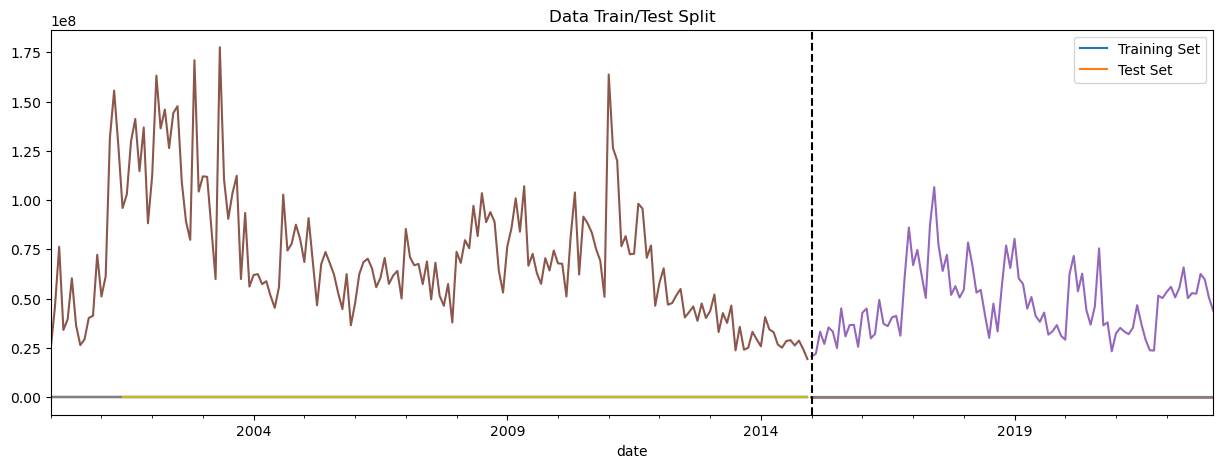

In [ ]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Train/Test Cross Validation

In [ ]:
# Split data n times and from those n datasets, set aside m number of test data points
tss = TimeSeriesSplit(n_splits=6, test_size=12*2, gap=0) # How much should gap be? 365 * 2
df = df.sort_index()

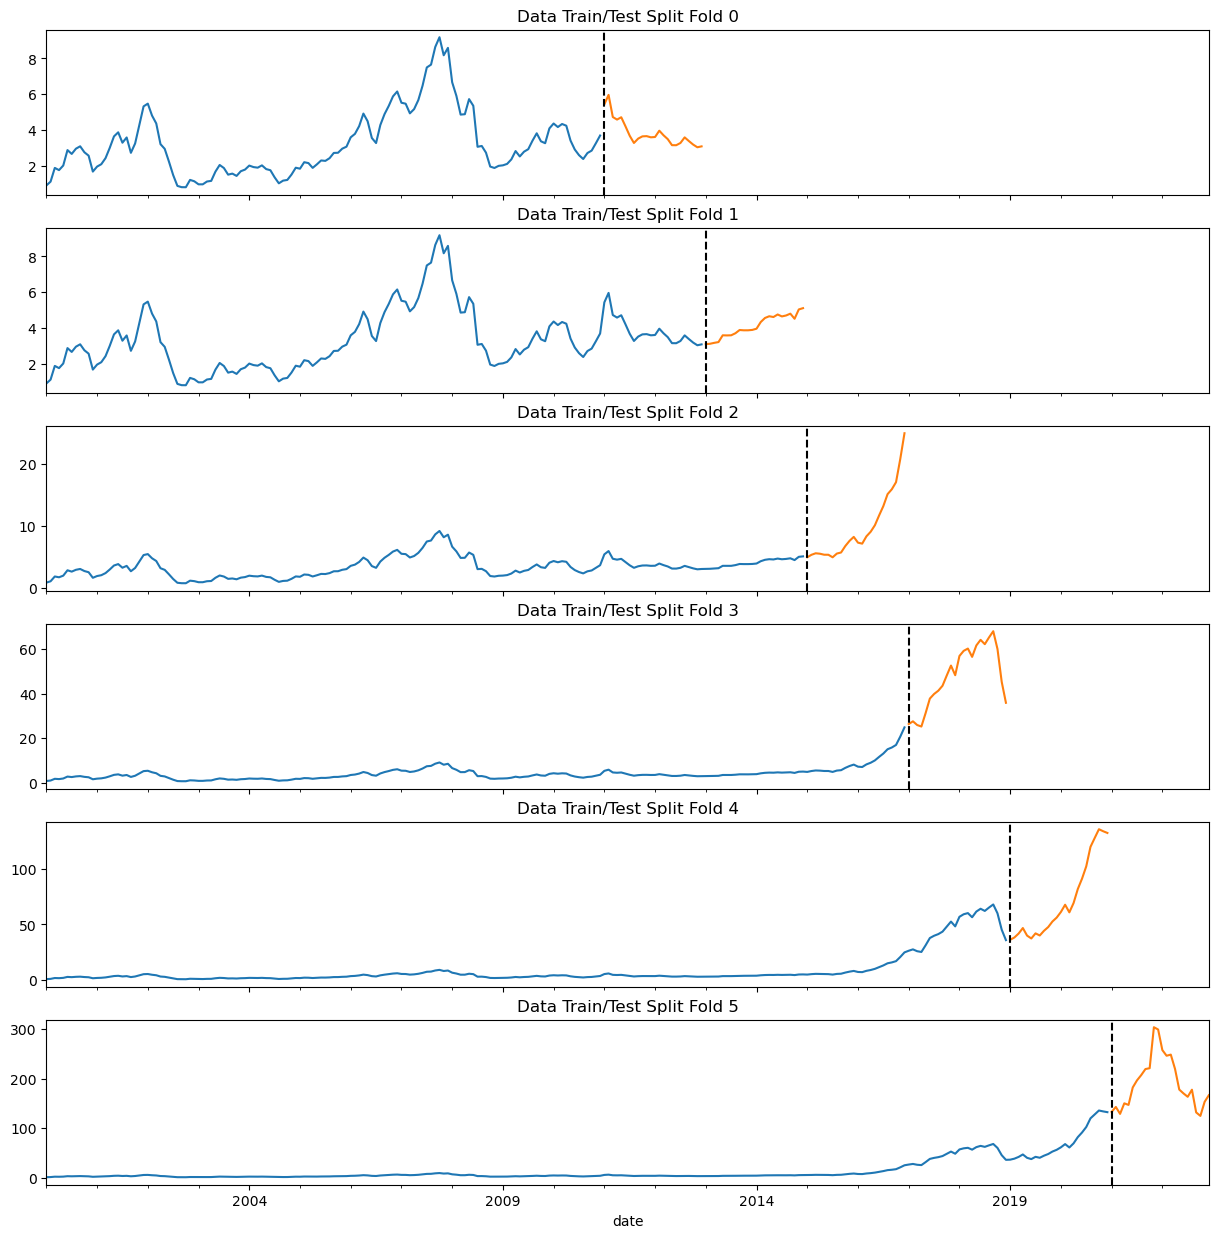

In [ ]:
fig, axs = plt.subplots(6, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    #print(val_idx)
    train = df.iloc[train_idx] # count of 12*2
    test = df.iloc[val_idx]
    train['close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['close'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
feature_df = create_features(df)
TARGET = ["close", "volume", "spy_close", "qqq_close"] # , "vti_close"
time_based_features = ["quarter", "month", "year"]
feature_df = feature_df[TARGET + time_based_features]
feature_df

,close,quarter,month,year
date,,,,
2000-01-01,0.886068,1,1,2000
2000-02-01,1.101628,1,2,2000
2000-03-01,1.870429,1,3,2000
2000-04-01,1.746214,2,4,2000
2000-05-01,2.005001,2,5,2000
...,...,...,...,...
2022-08-01,177.622608,3,8,2022
2022-09-01,131.744284,3,9,2022
2022-10-01,124.698095,4,10,2022


In [ ]:
lagged_df, lag_lst = add_lags(feature_df, 25, TARGET)
lagged_df

,close,quarter,month,year,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5,close_lag_6,...,close_lag_15,close_lag_16,close_lag_17,close_lag_18,close_lag_19,close_lag_20,close_lag_21,close_lag_22,close_lag_23,close_lag_24
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0.886068,1,1,2000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,1.101628,1,2,2000,0.886068,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,1.870429,1,3,2000,1.101628,0.886068,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,1.746214,2,4,2000,1.870429,1.101628,0.886068,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,2.005001,2,5,2000,1.746214,1.870429,1.101628,0.886068,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,177.622608,3,8,2022,163.304001,170.159047,177.905714,219.607001,248.516521,246.289473,...,146.881999,150.102975,128.761088,142.772764,132.878553,132.247387,133.789250,135.597500,127.729525,119.750714
2022-09-01,131.744284,3,9,2022,177.622608,163.304001,170.159047,177.905714,219.607001,248.516521,...,182.186704,146.881999,150.102975,128.761088,142.772764,132.878553,132.247387,133.789250,135.597500,127.729525
2022-10-01,124.698095,4,10,2022,131.744284,177.622608,163.304001,170.159047,177.905714,219.607001,...,196.463452,182.186704,146.881999,150.102975,128.761088,142.772764,132.878553,132.247387,133.789250,135.597500


In [ ]:
FEATURES = ['quarter', 'month', 'year']
FEATURES = FEATURES + lag_lst
lagged_df = lagged_df.sort_index()

tss = TimeSeriesSplit(n_splits=5, test_size=12*2, gap=0)

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(lagged_df):
    train = lagged_df.iloc[train_idx]
    test = lagged_df.iloc[val_idx]

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

[01:44:47] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.22909	validation_1-rmse:3.61150
[100]	validation_0-rmse:1.32101	validation_1-rmse:1.42111
[200]	validation_0-rmse:0.60528	validation_1-rmse:0.67644
[300]	validation_0-rmse:0.34598	validation_1-rmse:0.38877
[400]	validation_0-rmse:0.25601	validation_1-rmse:0.32320
[498]	validation_0-rmse:0.21759	validation_1-rmse:0.31627
[01:44:53] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.28212	validation_1-rmse:10.55726
[100]	validation_0-rmse:1.32457	validation_1-rmse:7.51183
[200]	validation_0-rmse:0.59813	validation_1-rmse:6.29394
[300]	validation_0-rmse:0.33831	validation_1-rmse:5.96084
[400]	validation_0-rmse:0.25039	validation_1-rmse:5.93875
[500]	validation_0-rmse:0.21537	validation_1-rmse:5.89926
[600]	validation_0-rmse:0.18651	validation_1-rmse:5.87999
[700]	valid

## Predicting the Future

In [14]:
# Train on all data
FEATURES = ['quarter', 'month', 'year']
FEATURES = FEATURES + lag_lst

X_all = lagged_df[FEATURES]
y_all = lagged_df[TARGET]
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       #early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)


# df_copy = df.copy()

# # Create future dataframe
# future = pd.date_range('2022-12-1','2023-11-1', freq='1m')
# future_df = pd.DataFrame(index=future)
# future_df['isFuture'] = True
# future_df.index = future_df.index.map(first_day_of_month)

# df_copy['isFuture'] = False
# df_and_future = pd.concat([df_copy, future_df])
# df_and_future = create_features(df_and_future)
# df_and_future, _ = add_lags(df_and_future, 25)

# future_w_features = df_and_future.query('isFuture').copy()

[18:06:39] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:34696627.92086
[100]	validation_0-rmse:14715821.77728
[200]	validation_0-rmse:7827399.11280
[300]	validation_0-rmse:5618342.47342
[400]	validation_0-rmse:4648317.69896
[500]	validation_0-rmse:4060212.99853
[600]	validation_0-rmse:3639197.12974
[700]	validation_0-rmse:3323344.32850
[800]	validation_0-rmse:3048192.27154
[900]	validation_0-rmse:2790930.71933
[999]	validation_0-rmse:2556934.90510


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

## Run Data through Model

In [78]:
def recursive_forecast(df, target_lst, horizon, num_lags):
    """
    Produce forecasts on feature engineered data frame (e.g. lagged and categorical features...)
    
    :param df: featured engineered data frame
    """
    for forecast_step in reversed(range(0, horizon)):
        
        # Forecast
        res = reg.predict(df.iloc[-1:][FEATURES]) # Predict using features | [Last Total Rows Generated, Specific Row from the end]
        future_date = df.index.max() + relativedelta.relativedelta(months=1) # Derive future date

        step_ahead_forecast = {'date': future_date, 'isFuture': True}
        for idx, target in enumerate(target_lst): # Save forecast 
            step_ahead_forecast[target] = res[0][idx] # forecast is in the follow format: [[val_1, val_2, ...]]
        step_ahead_df = pd.DataFrame(step_ahead_forecast, index = [0]) # Save forecast result in step ahead. Index set to zero to use scalars
        step_ahead_df.set_index("date", inplace= True)
        step_ahead_df = create_features(step_ahead_df) # Create features for latest row of data
        df = pd.concat([df, step_ahead_df]) # Combine new row of data with existing row
        df, _ = add_lags(df, num_lags, target_lst) # Add lags to the latest row of data
        
    return df

In [46]:
lagged_df.index.max()

Timestamp('2022-12-01 00:00:00')

In [16]:
# Produce Future Forecasts
forecast_results = recursive_forecast(df = lagged_df, target_lst = TARGET, horizon = 18, num_lags = 25)

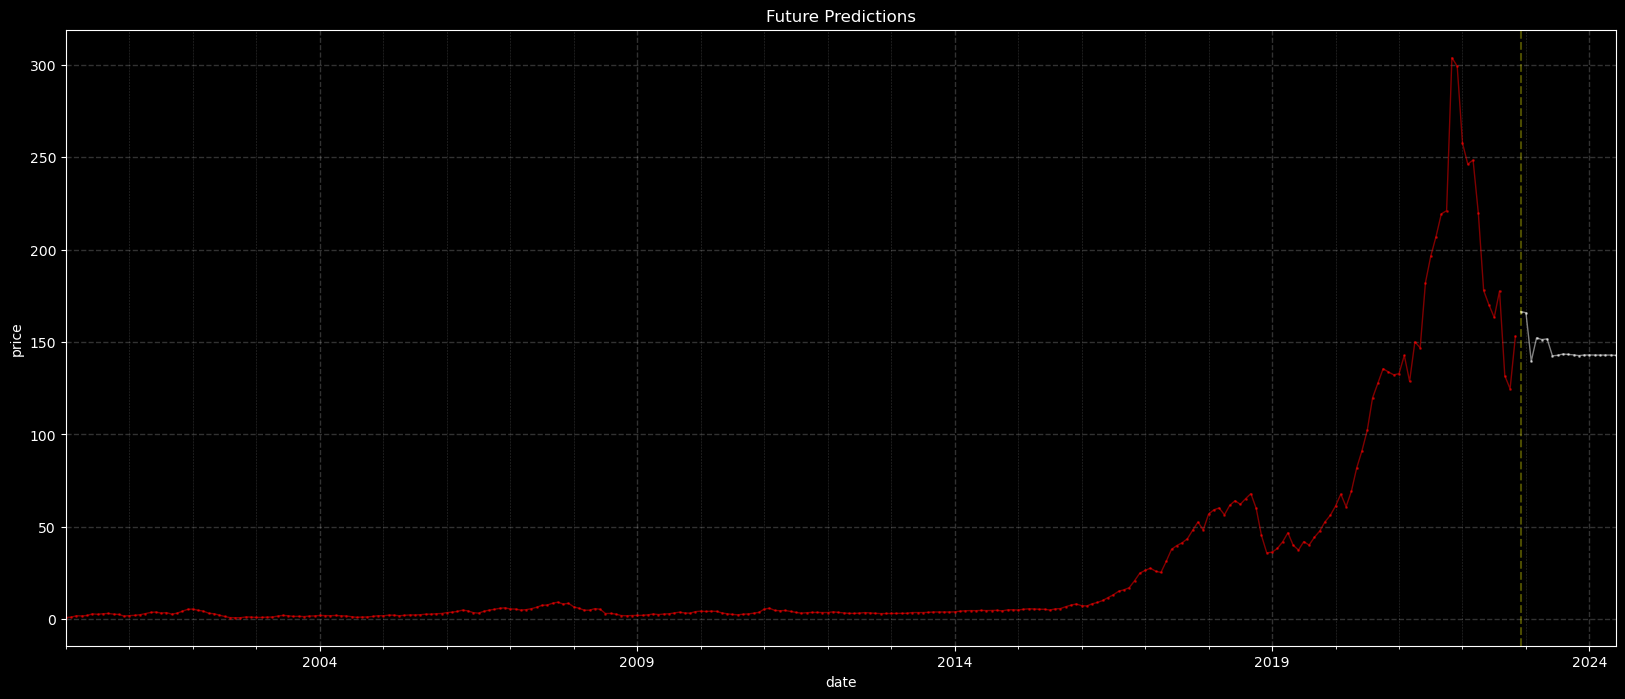

In [69]:
#Plot Values
plt.style.use('dark_background')

signal_to_plot = "close"

fig, ax = plt.subplots()

past_df = forecast_results.loc[forecast_results.index < '12-01-2022']
future_df = forecast_results.loc[forecast_results.index >= '12-01-2022']
future_df[signal_to_plot].plot(figsize=(20, 8),
                               color="white",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
past_df[signal_to_plot].plot(figsize=(20, 8),
                               color="red",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

ax.axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
ax.grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
ax.grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)
#fig.autofmt_xdate()
plt.show()

# Sklearn Shit
- https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html
- https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1

In [27]:
lagged_df

,close,volume,spy_close,qqq_close,quarter,month,year,close_lag_1,close_lag_2,close_lag_3,...,qqq_close_lag_15,qqq_close_lag_16,qqq_close_lag_17,qqq_close_lag_18,qqq_close_lag_19,qqq_close_lag_20,qqq_close_lag_21,qqq_close_lag_22,qqq_close_lag_23,qqq_close_lag_24
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0.886068,2.470728e+07,142.762500,90.579688,1,1,2000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,1.101628,4.580424e+07,139.070312,100.298438,1,2,2000,0.886068,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,1.870429,7.631374e+07,144.610734,111.057405,1,3,2000,1.101628,0.886068,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,1.746214,3.411436e+07,146.337171,93.633224,2,4,2000,1.870429,1.101628,0.886068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,2.005001,3.952538e+07,142.016335,85.187500,2,5,2000,1.746214,1.870429,1.101628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,177.622608,5.247673e+07,415.121306,319.086517,3,8,2022,163.304001,170.159047,177.905714,...,328.312004,336.944763,314.386955,328.259473,317.751579,307.658637,289.987502,282.750001,276.304766,278.096190
2022-09-01,131.744284,6.252656e+07,384.234288,288.663334,3,9,2022,177.622608,163.304001,170.159047,...,342.799092,328.312004,336.944763,314.386955,328.259473,317.751579,307.658637,289.987502,282.750001,276.304766
2022-10-01,124.698095,5.975846e+07,371.559524,273.160002,4,10,2022,131.744284,177.622608,163.304001,...,361.768100,342.799092,328.312004,336.944763,314.386955,328.259473,317.751579,307.658637,289.987502,282.750001


In [30]:
from sklearn.tree import DecisionTreeRegressor

X_train = lagged_df['qqq_close'].values.reshape(-1,1)
y_train = lagged_df['close'].values.reshape(-1,1)
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X=X_train, y=y_train)


DecisionTreeRegressor(random_state=42)

In [31]:
shift_steps = 1
lagged_df['close'].shift(-shift_steps)

date
2000-01-01      1.101628
2000-02-01      1.870429
2000-03-01      1.746214
2000-04-01      2.005001
2000-05-01      2.868800
                 ...    
2022-08-01    131.744284
2022-09-01    124.698095
2022-10-01    153.135715
2022-11-01    166.521765
2022-12-01           NaN
Name: close, Length: 276, dtype: float64

In [32]:
df_shifted = lagged_df['close'].shift(-shift_steps)
df_shifted

date
2000-01-01      1.101628
2000-02-01      1.870429
2000-03-01      1.746214
2000-04-01      2.005001
2000-05-01      2.868800
                 ...    
2022-08-01    131.744284
2022-09-01    124.698095
2022-10-01    153.135715
2022-11-01    166.521765
2022-12-01           NaN
Name: close, Length: 276, dtype: float64

In [21]:
lagged_df['close'].values[-shift_steps:]

array([166.52176529])

In [22]:
lagged_df.index[0]

Timestamp('2000-01-01 00:00:00')

In [23]:
n=10
date_col = 'Date'
last_date = lagged_df.index[-1:]#.to_numpy()
forecasted_dates = pd.date_range(last_date[0], periods=n+1, freq='M')[1:]

In [24]:
shift_steps = 1
df_shifted = lagged_df['close'].shift(-shift_steps)
X = lagged_df['close'].values.reshape(-1, 1)
y = df_shifted.values[:-shift_steps] # do not include last n values as it's NaN

In [25]:
# Fit the model on all of the data
model = DecisionTreeRegressor()
model.fit(X, y)

# Make forecasts for the next n time steps
n = 10
X_forecast = lagged_df['close'].values[-shift_steps:] # Get last value
y_forecast = model.predict(X_forecast)

# Append the forecasts to the original time series
df_forecast = lagged_df['close'].copy()
df_forecast['Forecast'] = np.concatenate((y, y_forecast))

# Create a forecasted date column
date_col = 'date'
last_date = lagged_df.index[-1:]
forecasted_dates = pd.date_range(last_date[0], periods=n+1, freq='M')[1:] # Converted last_date to scalar
df_forecast[date_col] = np.concatenate((lagged_df.index, forecasted_dates))

ValueError: Number of labels=275 does not match number of samples=276

In [76]:
X_train[-1:]

array([['2022-12-01T00:00:00.000000000']], dtype='datetime64[ns]')

In [69]:
X_train[-1:] .astype('datetime64[M]') + 1

array([['2023-01']], dtype='datetime64[M]')

In [71]:
dt_reg.predict(X_train[-1:]) 


array([166.52176529])

In [ ]:
        future_date = df.index.max() + relativedelta.relativedelta(months=1) # Derive future date
